In [1]:
# Import packages
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import seaborn as sns

%matplotlib inline
import hvplot.pandas
import plotly.express as px
import panel as pn

In [2]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

In [3]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [4]:
# Extracting data from Alpaca
ticker = ["SPY", "AGG",'IAU', "USO", "QQQ"]
timeframe = "1D"
start_date = pd.Timestamp('2009-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)


In [5]:
#change index strucutre
from datetime import datetime
df.index = df.index.strftime('%Y-%m-%d')
df.index = pd.to_datetime(df.index)
df.columns = ['AGG','IAU','QQQ','SPY','USO']

In [6]:
#Spot an outlier from the plot
df.hvplot(figsize = (12,8))



:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [7]:
#check the data points
df['2010-06-20':'2010-06-25']

AGG      IAU    QQQ     SPY    USO
2010-06-21  106.21   12.051  42.64  111.36  35.30
2010-06-22  106.39   12.149  42.31  109.57  35.02
2010-06-23  106.71  121.060  46.06  109.21  34.23
2010-06-24  106.62   12.140  45.34  107.44  34.39
2010-06-25  106.71   12.290  45.26  107.89  35.66

In [8]:
#As we can see from the plot, there is an apparent outlier which happens in every data processing.
# After cross-validating with Yahoo Finance, we modified this outlier into correct value
df['IAU'] = df['IAU'].replace(df['IAU'].max(), 12.106)

In [9]:
#double check and re-plot
df.hvplot(figsize = (12,8))

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [10]:
#Monthly data transformation
monthly_df=df.resample('M').mean()
#kind of wired, change the columns 
monthly_df.columns = ['AGG','IAU','QQQ','SPY','USO']

In [11]:
#Add plot here
monthly_df.hvplot()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [12]:
corr=monthly_df.corr()
corr

AGG       IAU       QQQ       SPY       USO
AGG  1.000000  0.591378  0.343803  0.394707 -0.316638
IAU  0.591378  1.000000 -0.043639 -0.053647  0.269738
QQQ  0.343803 -0.043639  1.000000  0.988227 -0.825427
SPY  0.394707 -0.053647  0.988227  1.000000 -0.820875
USO -0.316638  0.269738 -0.825427 -0.820875  1.000000

In [13]:
corr.hvplot.heatmap(title='Correlation Between ETFs')

:HeatMap   [columns,index]   (value)

In [14]:
# Calculate the monthly returns for the stocks
monthly_returns = monthly_df.pct_change().dropna()

# Display sample data
monthly_returns.head()

AGG       IAU       QQQ       SPY       USO
2009-02-28 -0.015056  0.090508 -0.004444 -0.067160 -0.172949
2009-03-31 -0.006482 -0.016275 -0.026977 -0.059219  0.098181
2009-04-30  0.003164 -0.039086  0.140047  0.117278  0.005759
2009-05-31  0.005353  0.042610 -0.010075  0.066222  0.127125
2009-06-30 -0.004383  0.017446  0.067476  0.026181  0.162621

In [15]:
#plot daily return
returns=df.pct_change().dropna()
returns.columns=['AGG','IAU','QQQ','SPY','USO']
returns.head()

AGG       IAU       QQQ       SPY       USO
2009-01-05  0.013952 -0.021772 -0.000322 -0.001829  0.046042
2009-01-06 -0.005703  0.008879  0.009674  0.006897 -0.000268
2009-01-07 -0.008700 -0.028280 -0.027787 -0.029324 -0.107919
2009-01-08 -0.008969  0.020891  0.010844  0.004190 -0.001204
2009-01-09 -0.003503 -0.006151 -0.022428 -0.022727 -0.025008

In [16]:
#return comparison
returns.hvplot(title='Daily Returns') +\
monthly_returns.hvplot(title="Monthly Returns")

:Layout
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [index]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Curve   [index]   (value)

In [17]:
# Compute monthly volatility
monthly_volatility = monthly_returns.std()
agg_volatility = monthly_volatility["AGG"]
iau_volatility = monthly_volatility["IAU"]
qqq_volatility = monthly_volatility["QQQ"]
spy_volatility = monthly_volatility["SPY"]
uso_volatility = monthly_volatility["USO"]

In [18]:
monthly_volatility

AGG    0.007364
IAU    0.034658
QQQ    0.039045
SPY    0.030525
USO    0.076636
dtype: float64

In [19]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [20]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(5)
        weights = weights/np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [21]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    #created equally weighted portfolio 
    equal_wei_std, equal_wei_returns = portfolio_annualised_performance(np.array([0.2,0.2,0.2,0.2,0.2]),mean_returns,cov_matrix)

    
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=df.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    max_return_idx = np.argmax(results[1])
    sd_max,r_max = results[0,max_return_idx],results[1,max_return_idx]
    max_ret_allocation = pd.DataFrame(weights[max_return_idx],index=df.columns,columns=['allocation'])
    max_ret_allocation.allocation = [round(i*100,2)for i in max_ret_allocation.allocation]
    max_ret_allocation = max_ret_allocation.T
    
    
    
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    print("-"*80)
    print("Maximum Return Portfolio Allocation\n")
    print("Annualised Return:", round(r_max,2))
    print("Annualised Volatility:", round(sd_max,2))
    print("\n")
    print(max_ret_allocation)
    
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.scatter(sd_max,r_max,marker = "*", color = "black", s = 500, label='Maximum return')
    plt.scatter(equal_wei_std,equal_wei_returns,marker = '*', color = "b", s = 500, label = "Equally weighted Portfolio")
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

In [22]:
#data preparation and input. Here we use monthly return since we have more than 10-years of data
returns = df.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 250000
#three-month U.S. Treasury bill 
risk_free_rate = 0.001
monthly_return = monthly_df.mean()
monthly_cov_matrix= monthly_df.cov()

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.07
Annualised Volatility: 0.07


              AGG    IAU  QQQ   SPY  USO
allocation  47.69  13.91  8.6  29.7  0.1
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.02
Annualised Volatility: 0.03


              AGG   IAU   QQQ   SPY  USO
allocation  88.53  3.26  3.07  4.64  0.5
--------------------------------------------------------------------------------
Maximum Return Portfolio Allocation

Annualised Return: 0.21
Annualised Volatility: 0.3


             AGG  IAU    QQQ   SPY   USO
allocation  2.22  1.2  94.16  1.01  1.41


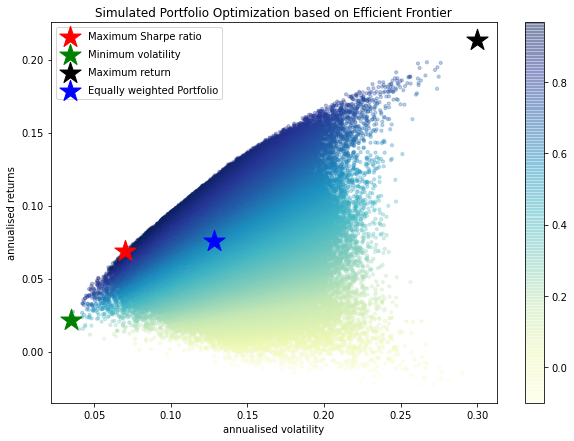

In [23]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 20090.73
Annualised Volatility: 35.44


              AGG    IAU  QQQ   SPY   USO
allocation  68.44  23.06  0.4  0.17  7.94
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 12522.87
Annualised Volatility: 32.47


              AGG    IAU   QQQ   SPY   USO
allocation  36.23  54.98  1.21  0.24  7.34
--------------------------------------------------------------------------------
Maximum Return Portfolio Allocation

Annualised Return: 42879.88
Annualised Volatility: 862.47


             AGG   IAU   QQQ    SPY  USO
allocation  9.46  2.58  2.93  83.63  1.4


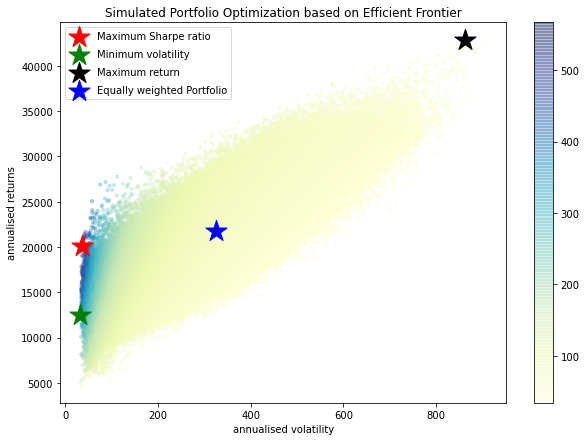

In [24]:
display_simulated_ef_with_random(monthly_return, monthly_cov_matrix, num_portfolios, risk_free_rate)

In [25]:
# Monte Carlo by monthly data
num_simulations = 100
num_trading_days = 252
monthly_return = monthly_df.pct_change()
avg_agg = monthly_return['AGG'].mean()
avg_iau = monthly_return['IAU'].mean()
avg_qqq = monthly_return['QQQ'].mean()
avg_spy = monthly_return['SPY'].mean()
avg_uso = monthly_return['USO'].mean()

std_agg = monthly_return['AGG'].std()
std_iau = monthly_return['IAU'].std()
std_qqq = monthly_return['QQQ'].std()
std_spy = monthly_return['SPY'].std()
std_uso = monthly_return['USO'].std()

agg_last_price = monthly_df['AGG'][-1]
iau_last_price = monthly_df['IAU'][-1]
qqq_last_price = monthly_df['QQQ'][-1]
spy_last_price = monthly_df['SPY'][-1]
uso_last_price = monthly_df['USO'][-1]
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()
for n in range(num_simulations):
    simulated_agg_prices = [agg_last_price]
    simulated_iau_prices = [iau_last_price]
    simulated_qqq_prices = [qqq_last_price]
    simulated_spy_prices = [spy_last_price]
    simulated_uso_prices = [uso_last_price]
    for i in range(num_trading_days):
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_agg, std_agg))
        simulated_iau_price = simulated_iau_prices[-1] * (1 + np.random.normal(avg_iau, std_iau))
        simulated_qqq_price = simulated_qqq_prices[-1] * (1 + np.random.normal(avg_qqq, std_qqq))
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_spy, std_spy))
        simulated_uso_price = simulated_uso_prices[-1] * (1 + np.random.normal(avg_uso, std_uso))
        simulated_agg_prices.append(simulated_agg_price)
        simulated_iau_prices.append(simulated_iau_price)
        simulated_qqq_prices.append(simulated_qqq_price)
        simulated_spy_prices.append(simulated_spy_price)
        simulated_uso_prices.append(simulated_uso_price)
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    simulated_price_df["IAU prices"] = pd.Series(simulated_iau_prices)
    simulated_price_df["QQQ prices"] = pd.Series(simulated_qqq_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    simulated_price_df["USO prices"] = pd.Series(simulated_uso_prices)
    simulated_daily_returns = simulated_price_df.pct_change()
    weights = [0.7245,0.0686,0.0189,0.0017,0.1863]
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

In [26]:
#result checking_similated prices
simulated_price_df.head()

AGG prices  IAU prices  QQQ prices  SPY prices  USO prices
0  112.548095   14.166667  207.971429  317.494762   12.497619
1  112.737493   14.905476  210.460446  319.364293   12.673426
2  113.806595   14.367182  223.621008  327.947086   13.743148
3  116.126509   15.126539  222.370208  319.563079   13.411341
4  113.595575   15.035575  227.177993  310.732163   13.251797

In [27]:
#result checking_similated retruns based on optimized weights
portfolio_cumulative_returns.head()

0         1         2         3         4         5         6   \
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1  1.001762  1.011281  1.001754  1.023480  0.985046  1.004154  1.001383   
2  0.984046  1.017052  1.008878  1.048971  0.996014  0.984125  1.004884   
3  0.984158  1.017285  1.013117  1.074857  0.982337  0.999772  1.019531   
4  1.006353  1.011247  1.031760  1.086289  1.015626  0.989043  1.018168   

         7         8         9   ...        90        91        92        93  \
0  1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000  1.000000   
1  1.007767  0.998078  0.988059  ...  0.981237  1.004311  1.006755  0.988065   
2  1.021116  0.996027  0.977694  ...  0.985616  1.021082  1.017669  0.987250   
3  1.019215  0.983505  0.962242  ...  0.975868  1.026337  0.991663  0.977926   
4  1.009472  1.006528  0.969112  ...  0.966922  1.058822  0.992316  0.970965   

         94        95        96        97        98        99  
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1  0.996819  0.994879  0.998121  1.015934  0.992970  1.007654  
2  0.982927  0.990073  0.990642  1.020722  1.006888  1.029163  
3  1.002867  1.001622  0.990828  1.044140  1.024312  1.043311  
4  1.018371  1.033614  1.018003  1.059155  1.004252  1.024472  

[5 rows x 100 columns]

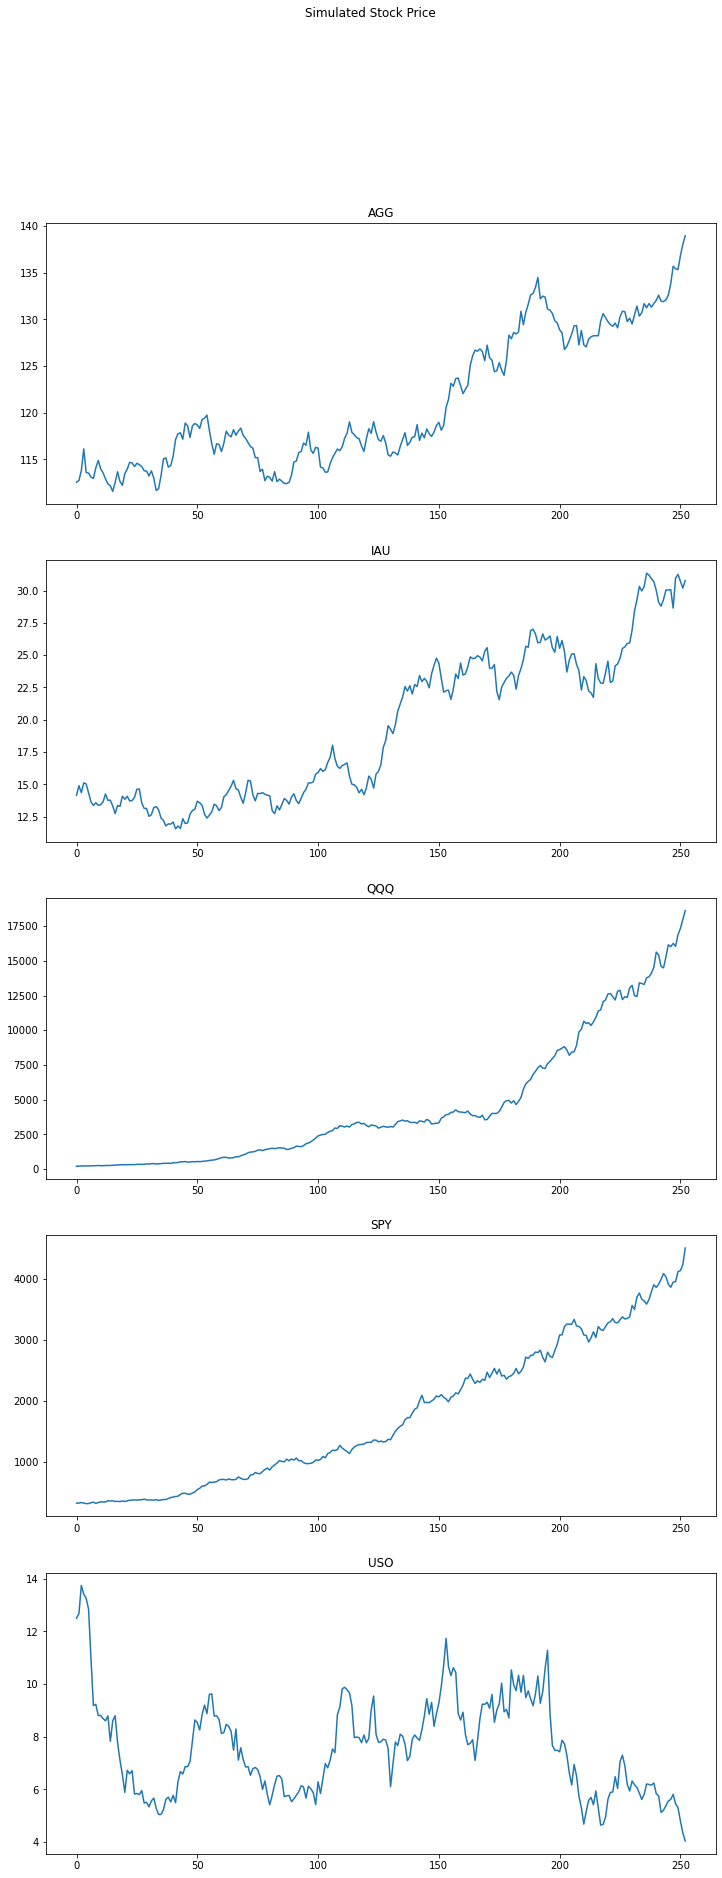

In [28]:
fig, axs = plt.subplots(5,figsize = (12,30))
fig.suptitle('Simulated Stock Price')
axs[0].plot(simulated_price_df['AGG prices'].index, simulated_price_df['AGG prices'])
axs[1].plot(simulated_price_df['IAU prices'].index, simulated_price_df['IAU prices'])
axs[2].plot(simulated_price_df['QQQ prices'].index, simulated_price_df['QQQ prices'])
axs[3].plot(simulated_price_df['SPY prices'].index, simulated_price_df['SPY prices'])
axs[4].plot(simulated_price_df['USO prices'].index, simulated_price_df['USO prices'])
axs[0].title.set_text('AGG')
axs[1].title.set_text('IAU')
axs[2].title.set_text('QQQ')
axs[3].title.set_text('SPY')
axs[4].title.set_text('USO')


In [29]:
simulated_price_df['AGG prices'].hvplot()

:Curve   [index]   (AGG prices)

In [30]:
simulated_price_df['IAU prices'].hvplot()

:Curve   [index]   (IAU prices)

In [31]:
simulated_price_df['QQQ prices'].hvplot()

:Curve   [index]   (QQQ prices)

In [32]:
simulated_price_df['SPY prices'].hvplot()

:Curve   [index]   (SPY prices)

In [33]:
simulated_price_df['USO prices'].hvplot()

:Curve   [index]   (USO prices)

In [34]:
simulated_price_df.hvplot()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

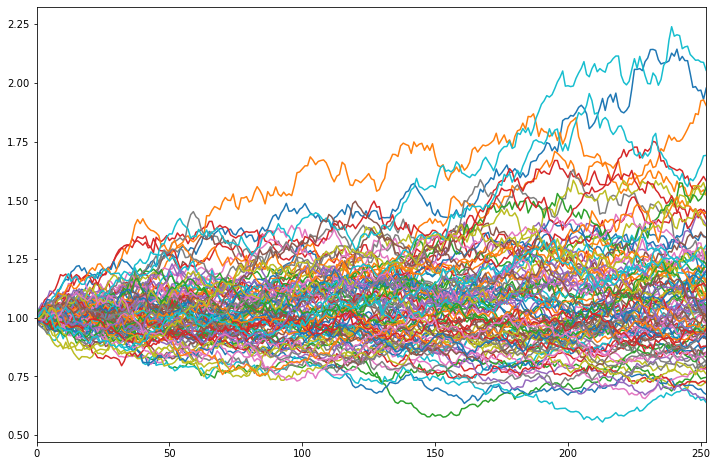

In [35]:
portfolio_cumulative_returns.plot(legend = False,figsize = (12,8))

In [36]:
portfolio_cumulative_returns.hvplot(title="portfolio cumulative returns",height=400)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [37]:
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()
confidence_interval = ending_cumulative_returns.quantile(q=[0.025, 0.975])
confidence_interval

0.025    0.696591
0.975    1.802695
Name: 252, dtype: float64

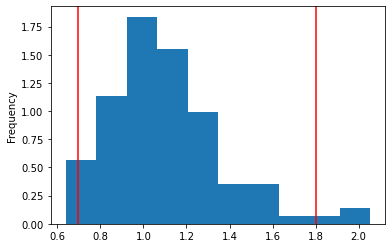

In [38]:
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

In [ ]:
# This is where our class presentation ended. 

In [40]:
# We added the CAPM study to further demonstrate the correlation between our portfolio and the market

SPY = df.SPY
SPY_ret = SPY.pct_change()
optimized_port = returns.dot(weights).rename('Optimized Portfolio')


In [41]:
#Visulization
consolidated = pd.concat([SPY_ret,optimized_port],axis = 1)
consolidated.hvplot()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [42]:
# We added the below Python library that we hadnt covered in class yet that allows us to fit the linear regression

import statsmodels.formula.api as smf 
excess = consolidated - risk_free_rate
excess.dropna(inplace = True)
excess.columns = ['Market_excess','Port_excess']
CAPM_model = smf.ols(formula='Port_excess ~ Market_excess', data= excess)

# Fit the regression
CAPM_fit = CAPM_model.fit()

# Extract the beta
regression_beta = CAPM_fit.params['Market_excess']
print(f"The beta for our portfolio vs market portfolio is {regression_beta}")


The beta for our portfolio vs market portfolio is 0.15043424722216014


In [43]:
#System development

# Here we enhanced the original Optimizer. We did this in an attempt to 1) combining Functions from the 
# first iteration as well as to allow the user to input as many securities into the optimzer as they wish

# It is important to note that in the below optimizer we used the same numbr of securities (5)that we used
# in the initial optimizer.
# We used the same 1) Data 2) mean_returns and 3) cov_matrix so that we could prove that the optimizer works

class optimizer:
    def __init__(self,number_of_stock,mean_returns,cov_matrix):
        self.number_of_stock = number_of_stock
        self.mean_returns = mean_returns
        self.cov_matrix = cov_matrix
  
    def display_simulated_ef_with_random(self, num_portfolios = 25000, risk_free_rate = 0.001):
        def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
            
            returns = np.sum(mean_returns*(weights) ) *252
            std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
            return std, returns
        def random_portfolios(mean_returns, cov_matrix, number_of_stock,num_portfolios = 25000,risk_free_rate = 0.001):
            results = np.zeros((3,25000))
            weights_record = []
            for i in range(25000):
                weights_t = np.random.random(int(self.number_of_stock))
                su = weights_t.sum()
                weights = weights_t/su
                weights_record.append(weights)
                portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
                results[0,i] = portfolio_std_dev
                results[1,i] = portfolio_return
                results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
                #print(portfolio_std_dev)
                #print(portfolio_return)
            return results, weights_record
    
    #created equally weighted portfolio 
        equal_wei_std, equal_wei_returns = portfolio_annualised_performance(np.array([0.2,0.2,0.2,0.2,0.2]),self.mean_returns,self.cov_matrix)

    
        results, weights = random_portfolios(self.mean_returns, self.cov_matrix,self.number_of_stock, num_portfolios,risk_free_rate)
            
        max_sharpe_idx = np.argmax(results[2])
        sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
        max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=df.columns,columns=['allocation'])
        max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
        max_sharpe_allocation = max_sharpe_allocation.T
    
        min_vol_idx = np.argmin(results[0])
        sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
        min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=df.columns,columns=['allocation'])
        min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
        min_vol_allocation = min_vol_allocation.T
    
        max_return_idx = np.argmax(results[1])
        sd_max,r_max = results[0,max_return_idx],results[1,max_return_idx]
        max_ret_allocation = pd.DataFrame(weights[max_return_idx],index=df.columns,columns=['allocation'])
        max_ret_allocation.allocation = [round(i*100,2)for i in max_ret_allocation.allocation]
        max_ret_allocation = max_ret_allocation.T
    
    
    
    
        print("-"*80)
        print("Maximum Sharpe Ratio Portfolio Allocation\n")
        print("Annualised Return:", round(rp,2))
        print("Annualised Volatility:", round(sdp,2))
        print("\n")
        print(max_sharpe_allocation)
        print("-"*80)
        print("Minimum Volatility Portfolio Allocation\n")
        print("Annualised Return:", round(rp_min,2))
        print("Annualised Volatility:", round(sdp_min,2))
        print("\n")
        print(min_vol_allocation)
        print("-"*80)
        print("Maximum Return Portfolio Allocation\n")
        print("Annualised Return:", round(r_max,2))
        print("Annualised Volatility:", round(sd_max,2))
        print("\n")
        print(max_ret_allocation)
    
    
        plt.figure(figsize=(10, 7))
        plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
        plt.colorbar()
        plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
        plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
        plt.scatter(sd_max,r_max,marker = "*", color = "black", s = 500, label='Maximum return')
        plt.scatter(equal_wei_std,equal_wei_returns,marker = '*', color = "b", s = 500, label = "Equally weighted Portfolio")
        plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
        plt.xlabel('annualised volatility')
        plt.ylabel('annualised returns')
        plt.legend(labelspacing=0.8)

In [44]:
returns = df.pct_change()
mean_returns = returns.mean()
cov_matrix_test = returns.cov()
num_portfolios = 250000
#three-month U.S. Treasury bill 
risk_free_rate = 0.001
monthly_return = monthly_df.mean()
monthly_cov_matrix= monthly_df.cov()

In [45]:
test = optimizer(number_of_stock=5,mean_returns= mean_returns,cov_matrix=cov_matrix_test)

In [46]:
mean_returns*np.array([0.2,0.2,0.2,0.2,0.2])

AGG    0.000006
IAU    0.000048
QQQ    0.000179
SPY    0.000100
USO   -0.000032
dtype: float64

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.06
Annualised Volatility: 0.07


              AGG   IAU   QQQ   SPY   USO
allocation  56.29  7.45  9.87  26.1  0.29
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.02
Annualised Volatility: 0.04


              AGG   IAU   QQQ   SPY   USO
allocation  82.95  4.76  0.42  8.39  3.48
--------------------------------------------------------------------------------
Maximum Return Portfolio Allocation

Annualised Return: 0.19
Annualised Volatility: 0.26


              AGG   IAU    QQQ   SPY   USO
allocation  11.02  0.85  81.87  3.98  2.28


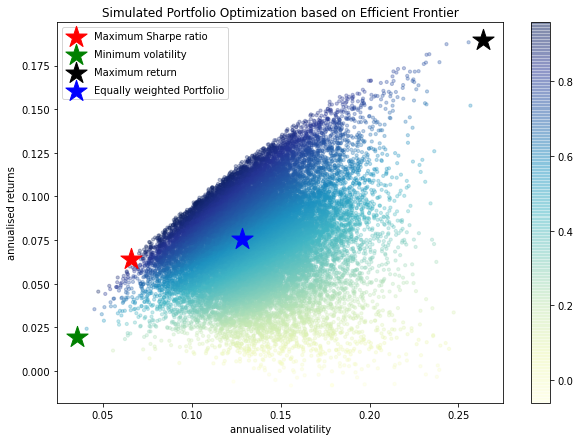

In [47]:
test.display_simulated_ef_with_random()

In [ ]:
# As you can see with the above vizualization, the optimizer again plots the portfolio with the optimal Sharpe ratio versus 
# a portfolio 1) with the least variance 2) the highest return and 3) a baselin 20% allocation to each of the 5 securities